In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as tud
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import pointbiserialr, chi2_contingency
import matplotlib.pyplot as plt

In [17]:

# hyper parameters: learning rate, dropout probability, number of epochs
LR          = 1e-3 
DROPOUT_P   = 0.3   
EPOCHS      = 100   

# -----------------------------------------------------------------------------#
# 1. loading the data   
# -----------------------------------------------------------------------------#
FILE = "oasis_cross_sectional.xlsx"
df   = pd.read_excel(FILE)

# rows without CDR (clinical dementia rating) are dropped because we need those values
df = df.dropna(subset=["CDR"])
df["label"] = (df["CDR"] > 0).astype(int)

numeric_cols      = ["Age", "Educ", "MMSE", "ASF", "eTIV", "nWBV"]
categorical_cols  = ["M/F", "Hand"]
df = df.dropna(subset=numeric_cols + categorical_cols).reset_index(drop=True)

numeric_xf     = Pipeline([("scaler", StandardScaler())])
categorical_xf = Pipeline([("ohe", OneHotEncoder(drop="first"))])

# combining the numeric and categorical transformers into a single preprocessor
pre = ColumnTransformer(
    [("num", numeric_xf, numeric_cols),
     ("cat", categorical_xf, categorical_cols)]
)

print(len(df))

X = pre.fit_transform(df)
y = df["label"].values

X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# converting data into pytorch tensors
X_tr = torch.tensor(X_tr, dtype=torch.float32)
y_tr = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_ds = tud.TensorDataset(X_tr, y_tr)
val_ds   = tud.TensorDataset(X_val, y_val)
train_dl = tud.DataLoader(train_ds, batch_size=(len(train_ds)))
val_dl   = tud.DataLoader(val_ds,   batch_size=len(val_ds))


235


In [18]:
# -----------------------------------------------------------------------------#
# 2. model definition
# -----------------------------------------------------------------------------#

#input feature dimension
in_dim = X_tr.shape[1]

#model: Sequential model with 3 linear layers and ReLU activations
model = nn.Sequential(
    nn.Linear(in_dim, 64),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(DROPOUT_P),
    nn.Linear(32, 1)        # logits
)

# check if running on GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = model.to(device)

pos_weight_val = (y_tr.shape[0] - y_tr.sum()) / y_tr.sum()
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_val.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)


In [19]:

# -----------------------------------------------------------------------------#
# 3. training
# -----------------------------------------------------------------------------#
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

for epoch in range(1, EPOCHS + 1):
    model.train()
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad() # gradient reset
        logits = model(xb) # forward pass
        loss   = criterion(logits, yb) # loss calculation
        loss.backward() # backprop
        optimizer.step() # update weights
    train_loss_hist.append(loss.item()) # training loss history

    model.eval()
    with torch.no_grad():
        for xb_val, yb_val in val_dl:
            xb_val, yb_val = xb_val.to(device), yb_val.to(device)
            val_logits = model(xb_val)
            val_loss   = criterion(val_logits, yb_val).item()
            preds      = (val_logits.sigmoid() > 0.5).float()
            val_acc    = (preds == yb_val).float().mean().item()
    val_loss_hist.append(val_loss)
    val_acc_hist.append(val_acc)

    #p rinting the training and validation loss and accuracy every 5 epoch
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:02d} | train_loss={loss.item():.4f} "
              f"| val_loss={val_loss:.4f} | val_acc={val_acc:.4f}")


Epoch 01 | train_loss=0.7793 | val_loss=0.7635 | val_acc=0.7660
Epoch 05 | train_loss=0.7459 | val_loss=0.7407 | val_acc=0.8085
Epoch 10 | train_loss=0.7269 | val_loss=0.7124 | val_acc=0.8298
Epoch 15 | train_loss=0.7200 | val_loss=0.6827 | val_acc=0.8511
Epoch 20 | train_loss=0.6912 | val_loss=0.6502 | val_acc=0.8511
Epoch 25 | train_loss=0.6620 | val_loss=0.6151 | val_acc=0.8298
Epoch 30 | train_loss=0.6166 | val_loss=0.5791 | val_acc=0.8298
Epoch 35 | train_loss=0.5805 | val_loss=0.5434 | val_acc=0.8298
Epoch 40 | train_loss=0.5614 | val_loss=0.5094 | val_acc=0.8298
Epoch 45 | train_loss=0.5444 | val_loss=0.4795 | val_acc=0.8298
Epoch 50 | train_loss=0.5060 | val_loss=0.4553 | val_acc=0.8298
Epoch 55 | train_loss=0.5204 | val_loss=0.4366 | val_acc=0.8298
Epoch 60 | train_loss=0.4538 | val_loss=0.4247 | val_acc=0.8298
Epoch 65 | train_loss=0.4708 | val_loss=0.4177 | val_acc=0.8298
Epoch 70 | train_loss=0.4640 | val_loss=0.4134 | val_acc=0.8298
Epoch 75 | train_loss=0.4710 | val_loss=

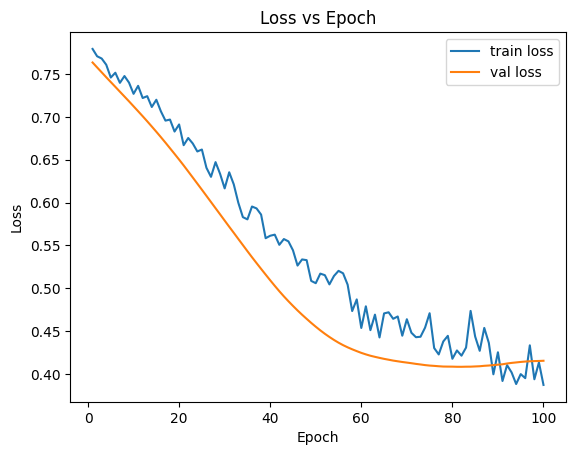

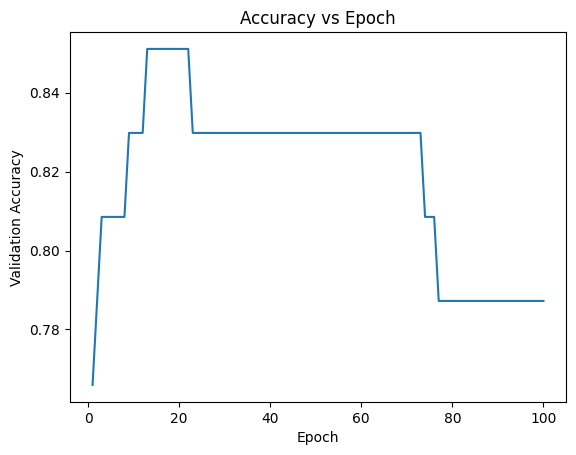

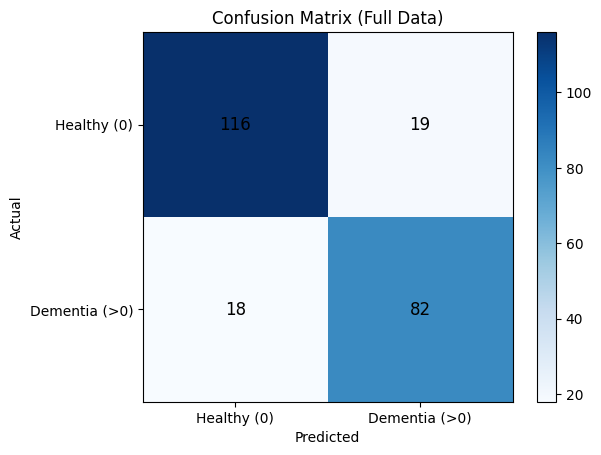

Classification report on validation set:
              precision    recall  f1-score   support

     Healthy       0.81      0.81      0.81        27
    Dementia       0.75      0.75      0.75        20

    accuracy                           0.79        47
   macro avg       0.78      0.78      0.78        47
weighted avg       0.79      0.79      0.79        47


Simple feature importance ranking
MMSE               0.6402   (numeric‑corr (|r|))
nWBV               0.4885   (numeric‑corr (|r|))
Age                0.3150   (numeric‑corr (|r|))
Educ               0.2359   (numeric‑corr (|r|))
eTIV               0.1304   (numeric‑corr (|r|))
ASF                0.1274   (numeric‑corr (|r|))


In [20]:
# -----------------------------------------------------------------------------#
# 4a. loss and accuracy
# -----------------------------------------------------------------------------#
ep = np.arange(1, EPOCHS + 1)

plt.figure()
plt.plot(ep, train_loss_hist, label="train loss")
plt.plot(ep, val_loss_hist,   label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss vs Epoch"); plt.legend(); plt.show()

plt.figure()
plt.plot(ep, val_acc_hist)
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy"); plt.title("Accuracy vs Epoch"); plt.show()

# -----------------------------------------------------------------------------#
# 4b. confusion matrix
# -----------------------------------------------------------------------------#
with torch.no_grad():
    yhat_val = (model(X_val.to(device)).sigmoid() > 0.5).cpu().numpy().astype(int).ravel()

cm = confusion_matrix(y, (model(torch.tensor(X, dtype=torch.float32).to(device))
                          .sigmoid() > 0.5).cpu().numpy().astype(int).ravel())
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Full Data)")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)
plt.xticks([0, 1], ["Healthy (0)", "Dementia (>0)"])
plt.yticks([0, 1], ["Healthy (0)", "Dementia (>0)"])
plt.colorbar(); plt.show()

print("Classification report on validation set:")
print(classification_report(y_val.numpy().ravel(), yhat_val, target_names=["Healthy", "Dementia"]))

# -----------------------------------------------------------------------------#
# 4‑c.  feature importance category attempt: numeric: point‑biserial correlation, categorical: chi‑square vs. label
# -----------------------------------------------------------------------------#
importance = []

# numeric correlations
for col in numeric_cols:
    r, p = pointbiserialr(df[col], df["label"])
    importance.append((col, abs(r), "numeric‑corr (|r|)"))

# one‑hot categorical stats
# get same encoding as we fed the model
cat_data = pre.named_transformers_["cat"]["ohe"].transform(df[categorical_cols])
cat_feature_names = pre.named_transformers_["cat"]["ohe"].get_feature_names_out(categorical_cols)


# sorted display

importance = sorted(importance, key=lambda x: x[1], reverse=True)
print("\nSimple feature importance ranking")
for name, score, kind in importance:
    print(f"{name:<15}  {score:>8.4f}   ({kind})")

Interpreting the results:

There is a graph with the history of the training and validation loss over the training epochs. After that there is a graph with the accuracy during each epoch. Then there is a confusion matrix with the two categories (demented vs non demented), which reveals how often each category is mistaken for others.

The classification report has details about the f1 score and overall accuracy. The simple feature importance ranking tries to show how important each feature is, and it seems to correlate the MMSE (mini mental state exam) as the most important, which makes sense as it assesses cognitive abilites.